##### 이번 노트북도 모델을 학습을 해야되서 Colab으로 진행해주세요.
##### 런타임 유형을 GPU로 바꾸고 해주세요.

### MMCV와 MMDetection import

In [ ]:
!pip install mmcv-full
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

### 설치 후 런타임 다시 시작

In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv

In [ ]:
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

### Balloon Dataset을 다운로드 후 압축 해제

In [ ]:
!mkdir data
!wget -O ./data/balloon_dataset.zip https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip

In [ ]:
# 다운받은 폴더 위치로 이동후 다운 받은 데이터 압출해제 하기
import os

os.chdir("./data/")
!unzip balloon_dataset.zip

In [ ]:
# 이전 디렉토리로 이동
os.chdir("..")

### balloon Json file을 Coco Format으로 convert

In [ ]:
import os.path as osp
import json
import cv2

from tqdm.notebook import tqdm

def convert_balloon_to_coco(ann_file, out_file,image_prefix):
    
    with open(ann_file) as json_file:
        data_infos = json.load(json_file)
    
    annotations = []
    images = []
    obj_counts = 0
    
    for idx, v in enumerate(tqdm(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = cv2.imread(img_path).shape[:2]
        
        images.append(dict(
            id = idx,
            file_name = filename,
            height = height,
            width = width
        ))
        
        bboxes = []
        labels = []
        masks = []
        
        for _, obj in v['regions'].items():
             
             #assert는 True이면 코드를 계속 진행 시키고, False이면 동작을 정지하고 AssertionError를 발생해라 라는 의미를 가지고있다.
             #따라서 obj['region_attributes']에는 값이 없으므로 False이다. not False이기 때문에 True 이므로 error가 발행하지
             #않는다. 마약 값이 있으면 obj['region_attributes']는 True를 반하고, not True이기 때문에 False가 되므로 error가
             #발생한다.
             
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px =obj['all_points_x']
            py =obj['all_points_y']
            
            # boundig box의 x, y, width, height를 segmentation 좌표 기반으로 구하기 위해, 최소/최대 x,y 좌표값을 구함.
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px,py)]
            poly = [p for x in poly for p in x] # [x1,y1,x2,y2, ...., x32,y32]로 바꾸어주는 역활
            
            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))
            
            data_anno = dict(
                image_id = idx,
                id = obj_counts,
                category_id = 0,
                bbox = [x_min, y_min, x_max - x_min, y_max - y_min],
                area = (x_max - x_min) * (y_max - y_min),
                segmentation = [poly],
                iscrowd = 0
            )
            
            annotations.append(data_anno)
            obj_counts += 1
    coco_format_json = dict(
        images = images,
        annotations = annotations,
        categories = [{'id':0, 'name':'balloon'}]
    )
    
    with open(out_file, 'w') as json_out_file:
        json.dump(coco_format_json, json_out_file)

In [ ]:
convert_balloon_to_coco('./data/balloon/train/via_region_data.json', './data/balloon/train_coco.json', './data/balloon/train')
convert_balloon_to_coco('./data/balloon/val/via_region_data.json', './data/balloon/val_coco.json', './data/balloon/val')

### Pretrained 모델 다운로드, Config 설정

In [ ]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬. 
!cd mmdetection; mkdir checkpoints

In [ ]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

In [ ]:
!ls -ail /content/mmdetection/checkpoints

### 데이터셋 등록 및 config 파일, checkpoint 파일 setting

In [26]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = './mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = './mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [27]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force = True)
class BalloonDataset(CocoDataset):
    CLASSES = ('balloon',)

In [28]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [ ]:
!cd mmdetection; mkdir work_dir

## Config file Setting

In [29]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'BalloonDataset'
cfg.data_root = "./data/balloon/"

cfg.data.train.type = 'BalloonDataset'
cfg.data.train.data_root = './data/balloon/'
cfg.data.train.ann_file = 'train_coco.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'BalloonDataset'
cfg.data.val.data_root = './data/balloon/'
cfg.data.val.ann_file = 'val_coco.json'
cfg.data.val.img_prefix = 'val'

cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12

cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'

cfg.runner.max_epochs = 36
cfg.checkpoint_config.interval = 12

cfg.log_config.interval = 10

cfg.load_from = "/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth"
cfg.work_dir = "/content/mmdetection/work_dir/"

cfg.seed = 0
set_random_seed(0, deterministic=False)

cfg.gpu_ids = range(1)

In [30]:
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

### Model Config -> Back Bone Setting

* MMDet_Tutorial: https://notebook.community/open-mmlab/mmdetection/demo/MMDet_Tutorial
* open-mmlab: https://github.com/open-mmlab/mmcv/blob/master/mmcv/model_zoo/open_mmlab.json#L48

In [6]:
import torch.nn as nn
from mmdet.models.builder import BACKBONES
from mmdet.models.backbones.resnext import ResNeXt

## 등록된 BackBone이 아닐 경우 실행
"""
@BACKBONES.register_module()
class DetectoRS_ResNeXt(nn.Module):
    
    def __init__(self, arg1, arg2):
        pass
    
    def forward(self, x):
        pass


custom_imports = dict(
    imports = ['mmdet.models.backbones.detectors_resnext'],
    allow_failed_imports = False
)
"""

"\n@BACKBONES.register_module()\nclass DetectoRS_ResNeXt(nn.Module):\n    \n    def __init__(self, arg1, arg2):\n        pass\n    \n    def forward(self, x):\n        pass\n\n\ncustom_imports = dict(\n    imports = ['mmdet.models.backbones.detectors_resnext'],\n    allow_failed_imports = False\n)\n"

In [31]:
cfg.model.backbone.type = "ResNeXt"
cfg.model.backbone.init_cfg.checkpoint = 'open-mmlab://jhu/resnext101_32x4d_gn'
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://jhu/resnext101_32x4d_gn')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropy

In [32]:
from mmdet.datasets.builder import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [33]:
datasets[0]


BalloonDataset Train dataset with number of images 61, and instance counts: 
+-------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
| category    | count | category | count | category | count | category | count | category | count |
+-------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
|             |       |          |       |          |       |          |       |          |       |
| 0 [balloon] | 255   |          |       |          |       |          |       |          |       |
+-------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+

In [34]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg = cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('balloon',)


In [35]:
train_detector(model=model, dataset=datasets, cfg=cfg, distributed=False, validate=True)

2021-10-14 21:25:55,514 - mmdet - INFO - load checkpoint from /home/bgw2001/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
2021-10-14 21:25:55,514 - mmdet - INFO - Use load_from_local loader
2021-10-14 21:25:55,651 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_h

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2021-10-14 21:26:04,092 - mmdet - INFO - Epoch [1][10/31]	lr: 2.500e-03, eta: 0:15:31, time: 0.842, data_time: 0.251, memory: 5888, loss_rpn_cls: 0.0520, loss_rpn_bbox: 0.0181, loss_cls: 0.3552, acc: 86.5137, loss_bbox: 0.3924, loss_mask: 0.4629, loss: 1.2805
2021-10-14 21:26:09,734 - mmdet - INFO - Epoch [1][20/31]	lr: 2.500e-03, eta: 0:12:50, time: 0.564, data_time: 0.015, memory: 5888, loss_rpn_cls: 0.0399, loss_rpn_bbox: 0.0144, loss_cls: 0.1581, acc: 94.1895, loss_bbox: 0.3300, loss_mask: 0.1036, loss: 0.6460
2021-10-14 21:26:15,094 - mmdet - INFO - Epoch [1][30/31]	lr: 2.500e-03, eta: 0:11:43, time: 0.536, data_time: 0.012, memory: 5888, loss_rpn_cls: 0.0188, loss_rpn_bbox: 0.0085, loss_cls: 0.0728, acc: 97.1387, loss_bbox: 0.1554, loss_mask: 0.1297, loss: 0.3851
2021-10-14 21:26:23,516 - mmdet - INFO - Epoch [2][10/31]	lr: 2.500e-03, eta: 0:11:54, time: 0.782, data_time: 0.233, memory: 5978, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0064, loss_cls: 0.0467, acc: 98.0957, loss_bbox: 

2021-10-14 21:29:37,030 - mmdet - INFO - Epoch [11][30/31]	lr: 2.500e-04, eta: 0:08:10, time: 0.569, data_time: 0.012, memory: 6012, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0023, loss_cls: 0.0255, acc: 99.1699, loss_bbox: 0.0392, loss_mask: 0.0621, loss: 0.1302
2021-10-14 21:29:45,558 - mmdet - INFO - Epoch [12][10/31]	lr: 2.500e-05, eta: 0:08:05, time: 0.798, data_time: 0.245, memory: 6012, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0067, loss_cls: 0.0386, acc: 98.5254, loss_bbox: 0.0603, loss_mask: 0.0708, loss: 0.1786
2021-10-14 21:29:51,351 - mmdet - INFO - Epoch [12][20/31]	lr: 2.500e-05, eta: 0:07:58, time: 0.579, data_time: 0.016, memory: 6012, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0054, loss_cls: 0.0344, acc: 98.7500, loss_bbox: 0.0583, loss_mask: 0.0695, loss: 0.1686
2021-10-14 21:29:57,162 - mmdet - INFO - Epoch [12][30/31]	lr: 2.500e-05, eta: 0:07:50, time: 0.581, data_time: 0.016, memory: 6012, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0040, loss_cls: 0.0218, acc: 99.2480, loss_bb

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 6.8 task/s, elapsed: 2s, ETA:     0s

2021-10-14 21:30:01,346 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-10-14 21:30:01,376 - mmdet - INFO - Evaluating segm...
/home/bgw2001/mmdetection/mmdet/datasets/coco.py:449: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
2021-10-14 21:30:01,406 - mmdet - INFO - Epoch(val) [12][13]	bbox_mAP: 0.7690, bbox_mAP_50: 0.8880, bbox_mAP_75: 0.8270, bbox_mAP_s: 0.2520, bbox_mAP_m: 0.5100, bbox_mAP_l: 0.8570, bbox_mAP_copypaste: 0.769 0.888 0.827 0.252 0.510 0.857, segm_mAP: 0.7980, segm_mAP_50: 0.8880, segm_mAP_75: 0.8430, segm_mAP_s: 0.3030, segm_mAP_m: 0.5230, segm_mAP_l: 0.8830, segm_mAP_copypaste: 0.798 0.888 0.843 0.303 0.523 0.883


DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.827
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.857
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
/home/bgw2001/mmcv/mmcv/runner/hooks/logger/text.py:55: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-10-14 21:30:09,346 - mmdet - INFO - Epoch [13][10/31]	lr: 2.500e-05, eta: 0:07:45, time: 0.793, data_time: 0.235, memory: 6012, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0040, loss_cls: 0.0283, acc: 99.0332, loss_bbox: 0.0412, loss_mask: 0.0571, loss: 0.1314
2021-10-14 21:30:15,141 - mmdet - INFO - Epoch [13][

2021-10-14 21:33:23,136 - mmdet - INFO - Epoch [22][30/31]	lr: 2.500e-05, eta: 0:04:35, time: 0.595, data_time: 0.019, memory: 6076, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0053, loss_cls: 0.0309, acc: 98.8184, loss_bbox: 0.0484, loss_mask: 0.0653, loss: 0.1506
2021-10-14 21:33:32,185 - mmdet - INFO - Epoch [23][10/31]	lr: 2.500e-05, eta: 0:04:28, time: 0.836, data_time: 0.249, memory: 6076, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0044, loss_cls: 0.0212, acc: 99.1992, loss_bbox: 0.0320, loss_mask: 0.0453, loss: 0.1040
2021-10-14 21:33:38,045 - mmdet - INFO - Epoch [23][20/31]	lr: 2.500e-05, eta: 0:04:22, time: 0.586, data_time: 0.018, memory: 6076, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0051, loss_cls: 0.0394, acc: 98.5645, loss_bbox: 0.0647, loss_mask: 0.0797, loss: 0.1898
2021-10-14 21:33:44,247 - mmdet - INFO - Epoch [23][30/31]	lr: 2.500e-05, eta: 0:04:15, time: 0.620, data_time: 0.016, memory: 6076, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0048, loss_cls: 0.0301, acc: 98.9551, loss_bb

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 6.4 task/s, elapsed: 2s, ETA:     0s

2021-10-14 21:34:08,785 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-10-14 21:34:08,811 - mmdet - INFO - Evaluating segm...
/home/bgw2001/mmdetection/mmdet/datasets/coco.py:449: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
2021-10-14 21:34:08,839 - mmdet - INFO - Epoch(val) [24][13]	bbox_mAP: 0.7700, bbox_mAP_50: 0.8880, bbox_mAP_75: 0.8270, bbox_mAP_s: 0.2520, bbox_mAP_m: 0.5100, bbox_mAP_l: 0.8590, bbox_mAP_copypaste: 0.770 0.888 0.827 0.252 0.510 0.859, segm_mAP: 0.7980, segm_mAP_50: 0.8880, segm_mAP_75: 0.8430, segm_mAP_s: 0.3030, segm_mAP_m: 0.5260, segm_mAP_l: 0.8830, segm_mAP_copypaste: 0.798 0.888 0.843 0.303 0.526 0.883


DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.827
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
/home/bgw2001/mmcv/mmcv/runner/hooks/logger/text.py:55: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-10-14 21:34:16,947 - mmdet - INFO - Epoch [25][10/31]	lr: 2.500e-05, eta: 0:03:49, time: 0.809, data_time: 0.233, memory: 6076, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0047, loss_cls: 0.0279, acc: 99.0723, loss_bbox: 0.0501, loss_mask: 0.0654, loss: 0.1496
2021-10-14 21:34:22,563 - mmdet - INFO - Epoch [25][

2021-10-14 21:37:31,544 - mmdet - INFO - Epoch [34][30/31]	lr: 2.500e-05, eta: 0:00:39, time: 0.579, data_time: 0.014, memory: 6078, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0038, loss_cls: 0.0319, acc: 98.7988, loss_bbox: 0.0503, loss_mask: 0.0693, loss: 0.1557
2021-10-14 21:37:40,121 - mmdet - INFO - Epoch [35][10/31]	lr: 2.500e-05, eta: 0:00:32, time: 0.792, data_time: 0.240, memory: 6078, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0058, loss_cls: 0.0351, acc: 98.7109, loss_bbox: 0.0591, loss_mask: 0.0744, loss: 0.1767
2021-10-14 21:37:45,526 - mmdet - INFO - Epoch [35][20/31]	lr: 2.500e-05, eta: 0:00:26, time: 0.540, data_time: 0.013, memory: 6078, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0026, loss_cls: 0.0233, acc: 99.1992, loss_bbox: 0.0377, loss_mask: 0.0524, loss: 0.1167
2021-10-14 21:37:51,435 - mmdet - INFO - Epoch [35][30/31]	lr: 2.500e-05, eta: 0:00:20, time: 0.591, data_time: 0.022, memory: 6078, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0075, loss_cls: 0.0328, acc: 98.7305, loss_bb

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 6.9 task/s, elapsed: 2s, ETA:     0s

2021-10-14 21:38:15,664 - mmdet - INFO - Evaluating bbox...
2021-10-14 21:38:15,690 - mmdet - INFO - Evaluating segm...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.827
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.861
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxD

/home/bgw2001/mmdetection/mmdet/datasets/coco.py:449: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
2021-10-14 21:38:15,724 - mmdet - INFO - Epoch(val) [36][13]	bbox_mAP: 0.7720, bbox_mAP_50: 0.8880, bbox_mAP_75: 0.8270, bbox_mAP_s: 0.2520, bbox_mAP_m: 0.5190, bbox_mAP_l: 0.8610, bbox_mAP_copypaste: 0.772 0.888 0.827 0.252 0.519 0.861, segm_mAP: 0.7990, segm_mAP_50: 0.8880, segm_mAP_75: 0.8430, segm_mAP_s: 0.3030, segm_mAP_m: 0.5350, segm_mAP_l: 0.8820, segm_mAP_copypaste: 0.799 0.888 0.843 0.303 0.535 0.882


DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.843
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.882
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.836
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.836
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.836
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

In [36]:
import mmcv
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

In [37]:
checkpoint_file = "/content/mmdetection/work_dir/epoch_36.pth"

model_ckpt = init_detector(cfg, checkpoint_file)


/home/bgw2001/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


/home/bgw2001/mmdetection/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/bgw2001/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


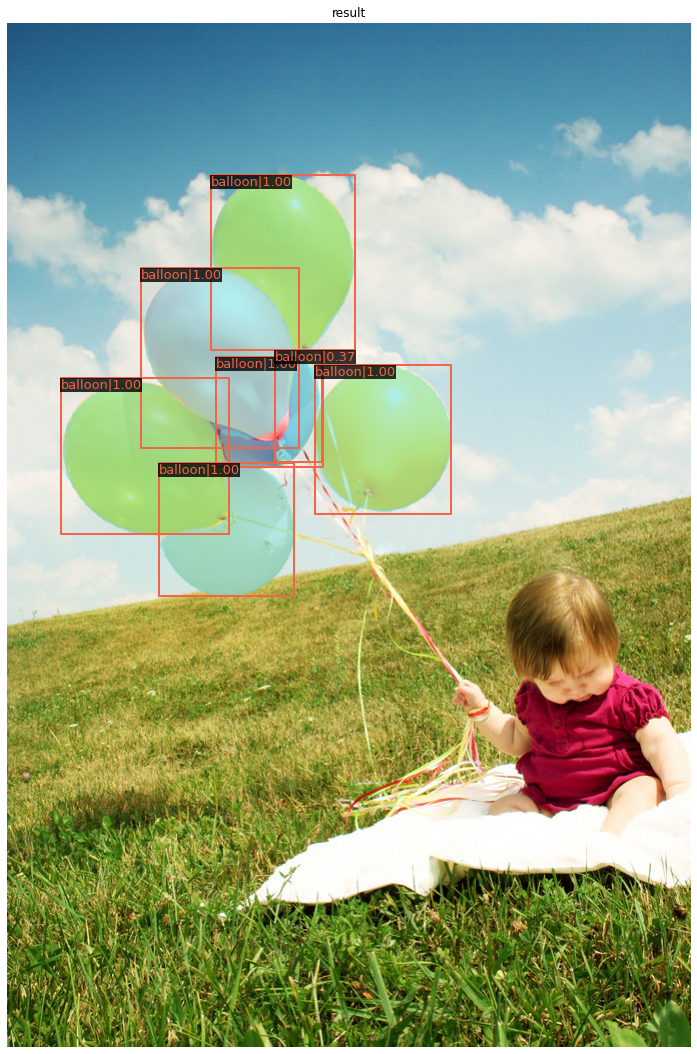

In [38]:
import cv2

img_arr = cv2.imread("./data/balloon/val/3825919971_93fb1ec581_b.jpg")

results = inference_detector(model_ckpt, img_arr)

show_result_pyplot(model_ckpt, img_arr, results)

In [39]:
import numpy as np

색상 RGB Table
* https://www.rapidtables.com/web/color/RGB_Color.html

In [48]:
label_to_seq = {0:'ballon'}

colors = [[255, 255, 51],
         [0, 255, 255],
         [0, 255, 128],
         [127, 0, 255],
         [255, 0, 127],
         [255, 51, 255],
         [51, 153, 255],
         [255, 204, 204]]

def get_detected_img(model, img_array, score_threshold = 0.3, gray_scale = True, draw_box = False, is_print = True):
    
    draw_img = img_array.copy()
    
    bbox_color = (250,235,215)
    text_color = (255,20,147)
    
    results = inference_detector(model, img_array)
    bbox_results = results[0]
    mask_results = results[1]
    
    if gray_scale:
        draw_img = cv2.cvtColor(cv2.cvtColor(draw_img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
    
    for result_ind, bbox_result in enumerate(bbox_results):
        
        if len(bbox_result) == 0:
            continue
            
        mask_array_list = mask_results[result_ind]
        
        for i in range(len(bbox_result)):
            
            if bbox_result[i,4] > score_threshold:
                left = int(bbox_result[i,0])
                top = int(bbox_result[i,1])
                right = int(bbox_result[i,2])
                bottom = int(bbox_result[i,3])
                
                caption = "{}: {:.4f}".format(label_to_seq[result_ind], bbox_result[i,4])
                
                
                if draw_box:
                    cv2.rectangle(draw_img, (left, top), (right, bottom), bbox_color, thickness = 2)
                    cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_TRIPLEX, 0.87, text_color, 1)
                
                mask_array = mask_array_list[i]
                mask_roi = draw_img[mask_array]
                
                color_ind = np.random.randint(0, len(colors) - 1)
                color = colors[color_ind]
                
                draw_img[mask_array] = ([0.3 * color[0], 0.3 * color[1], 0.3 * color[2]] + 0.6 * mask_roi).astype(np.uint8)
                
                if is_print:
                    caption
                
    return draw_img

In [49]:
detected_img = get_detected_img(model_ckpt, img_arr, score_threshold=0.3, gray_scale = True, draw_box = True, is_print = True)

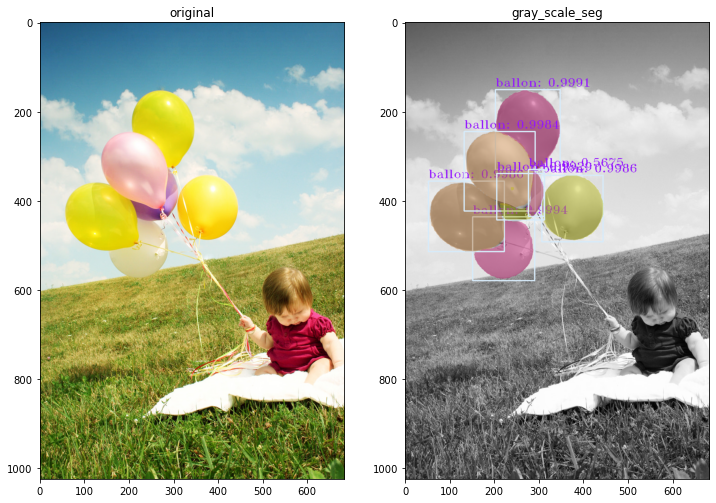

In [50]:
import matplotlib.pyplot as plt

img_arr = cv2.imread("./data/balloon/val/3825919971_93fb1ec581_b.jpg")
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (12,12))
plt.subplot(1,2,1)
plt.imshow(img_arr)
plt.title("original")

detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(detected_img, cmap = 'gray')
plt.title("gray_scale_seg")
plt.show()

### Video detect 하기

In [ ]:
# 데이터 다운로드
!wget -O /content/data/Balloons.mp4 https://github.com/Kang812/Object_Detection/raw/main/mmdet/data/Balloons.mp4

In [54]:
import cv2
import time

def video_frame_detected(model, input_path, output_path, score_threshold = 0.3, gray_scale = False, 
                         draw_box = False, vid_print = True, is_print = True):
    
    cap = cv2.VideoCapture(input_path)
    
    codec = cv2.VideoWriter_fourcc(*"XVID")
    
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("총 Frame 갯 수:",frame_cnt)
    frame_ind = 0
    
    btime = time.time()
    while True:
        
        hasFrame, img_frame = cap.read()
        
        if not hasFrame:
            break
        
        stime = time.time()
        img_frame = get_detected_img(model, img_frame, score_threshold = score_threshold, draw_box=draw_box,
                                    gray_scale = gray_scale, is_print = is_print)
        
        vid_writer.write(img_frame)
        frame_ind += 1
        
        if vid_print:
            print("frame_ind:{}, 완료 시간:{}".format(frame_ind, round(time.time() -  stime, 4)))
    
    print("완료 시간:", round(time.time() - btime, 4))
    vid_writer.release()
    cap.release()

In [57]:
# bounding Box(X), Gray_Scale(O)
video_frame_detected(model_ckpt, "./data/Balloons.mp4", "./data/Balloons_gray_scale.avi", score_threshold = 0.3, gray_scale = True, 
                         draw_box = False, vid_print = True, is_print = False)

총 Frame 갯 수: 220
frame_ind:1, 완료 시간:0.1601
frame_ind:2, 완료 시간:0.1412
frame_ind:3, 완료 시간:0.1326
frame_ind:4, 완료 시간:0.1363
frame_ind:5, 완료 시간:0.1331
frame_ind:6, 완료 시간:0.1353
frame_ind:7, 완료 시간:0.1329
frame_ind:8, 완료 시간:0.1373
frame_ind:9, 완료 시간:0.1375
frame_ind:10, 완료 시간:0.1356
frame_ind:11, 완료 시간:0.1335
frame_ind:12, 완료 시간:0.1361
frame_ind:13, 완료 시간:0.1338
frame_ind:14, 완료 시간:0.1372
frame_ind:15, 완료 시간:0.1346
frame_ind:16, 완료 시간:0.1379
frame_ind:17, 완료 시간:0.1324
frame_ind:18, 완료 시간:0.136
frame_ind:19, 완료 시간:0.1323
frame_ind:20, 완료 시간:0.1362
frame_ind:21, 완료 시간:0.1325
frame_ind:22, 완료 시간:0.1387
frame_ind:23, 완료 시간:0.1358
frame_ind:24, 완료 시간:0.1374
frame_ind:25, 완료 시간:0.1341
frame_ind:26, 완료 시간:0.1361
frame_ind:27, 완료 시간:0.1339
frame_ind:28, 완료 시간:0.1359
frame_ind:29, 완료 시간:0.1335
frame_ind:30, 완료 시간:0.1364
frame_ind:31, 완료 시간:0.1338
frame_ind:32, 완료 시간:0.1352
frame_ind:33, 완료 시간:0.1348
frame_ind:34, 완료 시간:0.1402
frame_ind:35, 완료 시간:0.137
frame_ind:36, 완료 시간:0.1395
frame_ind:37, 완료 시간:0.

In [58]:
# bounding Box(O), Gray_Scale(X)
video_frame_detected(model_ckpt, "./data/Balloons.mp4", "./data/Balloons_drawbox.avi", score_threshold = 0.3, gray_scale = False, 
                         draw_box = True, vid_print = True, is_print = False)

총 Frame 갯 수: 220
frame_ind:1, 완료 시간:0.171
frame_ind:2, 완료 시간:0.1602
frame_ind:3, 완료 시간:0.1538
frame_ind:4, 완료 시간:0.1571
frame_ind:5, 완료 시간:0.1531
frame_ind:6, 완료 시간:0.1575
frame_ind:7, 완료 시간:0.1558
frame_ind:8, 완료 시간:0.1601
frame_ind:9, 완료 시간:0.1562
frame_ind:10, 완료 시간:0.1587
frame_ind:11, 완료 시간:0.1558
frame_ind:12, 완료 시간:0.1589
frame_ind:13, 완료 시간:0.1579
frame_ind:14, 완료 시간:0.1633
frame_ind:15, 완료 시간:0.1586
frame_ind:16, 완료 시간:0.1579
frame_ind:17, 완료 시간:0.1556
frame_ind:18, 완료 시간:0.1606
frame_ind:19, 완료 시간:0.1547
frame_ind:20, 완료 시간:0.1583
frame_ind:21, 완료 시간:0.1552
frame_ind:22, 완료 시간:0.1666
frame_ind:23, 완료 시간:0.1822
frame_ind:24, 완료 시간:0.177
frame_ind:25, 완료 시간:0.1822
frame_ind:26, 완료 시간:0.1637
frame_ind:27, 완료 시간:0.1586
frame_ind:28, 완료 시간:0.1611
frame_ind:29, 완료 시간:0.1562
frame_ind:30, 완료 시간:0.1621
frame_ind:31, 완료 시간:0.1583
frame_ind:32, 완료 시간:0.1579
frame_ind:33, 완료 시간:0.1577
frame_ind:34, 완료 시간:0.1619
frame_ind:35, 완료 시간:0.1576
frame_ind:36, 완료 시간:0.1586
frame_ind:37, 완료 시간:0.

In [60]:
cfg.dump("./data/conf_resnext101_32x4d_gn.py")